<center>
    <span style="font-size: 1.0em; color:black"><b>
        June 27$^\mathrm{st}$, 2023
    </b></span>
    <br>
    <span style="font-size: 2.5em; color:black"><b>
        Work Notebook
    </b></span>
    <br>
    <span style="font-size: 0.75em;"><i>
        Eduardo J. Alvarez
    </i></span> 
    <br>
    <span style="font-size: 0.75em;"><i>
        The content of this notebook is intellectual property of <a href="https://www.whisper.aero/">Whisper Aero</a>. <br>
        No use or sharing of this information is allowed without written consent.
    </i></span> 
</center>

# DuctAPE &mdash; Neumann Solver

## Constant Doublet Panel Definition

An axisymmetric doublet panel is defined by its two end points $\mathbf{p}_1$ and $\mathbf{p}_2$ and its strength $\mu$. 

If $\mu$ is positive, the doublet panel is equivalent two vortex rings, one at each end point, as shown below, where a positive vortex ring strength $\Gamma$ is defined through the right-hand rule as a circulation coming out of the plane:

<img src="img/2ddoubletpanel00.png" alt="pic here" width="30%">

The normal $\hat{\mathbf{n}}$ of the panel is defined as shown above.

The velocity induced by such panels is computed as follows:

```julia
import DuctAPE as dt


"""
Returns the x-component of velocity induced by the vortex ring of strength 
`Gammasrc`  and position `Xsrc` at a target point `Xtrg`.
"""
function vx(Gammasrc, Xsrc, Xtrg)
    
    #= NOTE:
        * "j-th panel" = source
        * "affecting point" = source
        * "i-th" panel = target
        * "affected point" = target
    =#
    
    x, r, m, rj = dt.calculate_xrm(Xsrc, Xtrg)
    
    return Gammasrc * dt.get_vx_ring_vortex_off_body(x, r, rj, m)
    
end

"""
Returns the r-component of velocity induced by the vortex ring of strength 
`Gammasrc`  and position `Xsrc` at a target point `Xtrg`.
"""
function vr(Gammasrc, Xsrc, Xtrg)
    
    x, r, m, rj = dt.calculate_xrm(Xsrc, Xtrg)
    
    return Gammasrc * dt.get_vr_ring_vortex_off_body(x, r, rj, m)
    
end

"""
Calculate the velocity induced by axisymmetric doublet panel of strength `mu`
and end points `p1` and `p2` on target `Xtrg`. The velocity components are
added to the vector `out`. 
"""
function U_axisymdoublet!(out, mu, p1, p2, Xtrg)
    
    # NOTE: I have flipped the Gammas to be Γ1=-μ and Γ2=μ to account for the fact
    #       that Judd's implementation defined a positive Γ as a ring with circulation 
    #       going into the $xr$-plane
    
    # Velocity induced by p1 ring
    out[1] += vx(-mu, p1, Xtrg)
    out[2] += vr(-mu, p1, Xtrg)
    
    # Velocity induced by p2 ring
    out[1] += vx(mu, p2, Xtrg)
    out[2] += vr(mu, p2, Xtrg)
    
    return out
end

function U_axisymdoublet(mu::T1, 
                            p1::AbstractVector{T2}, p2::AbstractVector{T3}, 
                            Xtrg::AbstractVector{T4}) where {T1, T2, T3, T4}
    T = promote_type(T1, T2, T3, T4)
    out = zeros(T, 2)
    
    U_axisymdoublet!(out, mu, p1, p2, Xtrg)
    
    return out
end
```

NOTE
* $u_r$ is NaN at $r=0$
* $u_x$ is 0 at $x=x_0$ and $r=R$, instead of $\infty$
* A positive $\Gamma$ defines a ring with circulation going into the $xr$-plane (meaning, a ring traveling in the $-x$ direction)

As a reference here is the velocity field induced around an isolated constant doublet panel:
<img src="img/axisymdoublet00.png" alt="pic here" width="100%">

<img src="img/axisymdoublet01.png" alt="pic here" width="100%">

## No-Flow-Through Boundary Condition

The velocity $\mathbf{u}_i$ induced by a doublet panel of strength $\mu$ at an arbitrary position $\mathbf{x}$ is given by

\begin{align*}
    \mathbf{u}_i \left( \mathbf{x} \right) = \mu \mathbf{g}(\mathbf{x})
,\end{align*}

where the geometric function $\mathbf{g}$ is computed from the end points of the panel alone.
Given an axisymmetric body discretized into $N$ doublet panels, the velocity induced by the body at any point in space is then computed as

\begin{align*}
        \mathbf{u} \left( \mathbf{x} \right)
    = 
        \sum\limits_{i=1}^N \mathbf{u}_i \left( \mathbf{x} \right) 
    = 
        \sum\limits_{i=1}^N \mu_i \mathbf{g}_i(\mathbf{x})
.\end{align*}

In order to impose the no-flow-through condition, we require that the velocity induced by the body cancels out the normal component of the freestream velocity along the body:

\begin{align*}
    \mathbf{u} \left( \mathbf{x}_j \right) \cdot \hat{\mathbf{n}}_j
    + 
    \mathbf{u}_\infty \cdot \hat{\mathbf{n}}_j
    =
    0
\end{align*}

where $\mathbf{x}_j$ and $\hat{\mathbf{n}}_j$ are the control point and normal associated to the $j$-th target panel.

The no-flow-through condition can then be rewritten as


\begin{align*}
        \sum\limits_{i=1}^N \mu_i \mathbf{g}_i(\mathbf{x}_j) \cdot \hat{\mathbf{n}}_j
    =
        - \mathbf{u}_\infty \cdot \hat{\mathbf{n}}_j
,\end{align*}

which poses a system of $N$ equations (one for each $\mathbf{x}_j$) and $N$ unknowns (each $\mu_i$).
We rewrite this system of equations as

\begin{align*}
        G \boldsymbol\mu = \mathbf{b}
,\end{align*}

where $G$ is an $N\times N$ matrix containing the geometric information ($G_{ji} \equiv \mathbf{g}_i(\mathbf{x}_j) \cdot \hat{\mathbf{n}}_j$), $\boldsymbol\mu$ is the vector of doublet strengths, and $\mathbf{b}$ is the vector of boundary conditions ($b_j = - \mathbf{u}_\infty \cdot \hat{\mathbf{n}}_j$).

The geometric matrix $G$ is built as follows:

```julia
function G_axisymdoublet!(G, nodes::AbstractMatrix, panels, 
                                controlpoints::AbstractMatrix, normals::AbstractMatrix)
    
    # Iterate over boundary condition equations
    for (j, (xj, nj)) in enumerate(zip(eachcol(controlpoints), eachcol(normals)))
        
        # Iterate over panels inducing velocity
        for (i, panel) in enumerate(panels)
                
            # Fetch panel end points
            p1 = view(nodes, :, panel[1])
            p2 = view(nodes, :, panel[2])
                
            # Velocity induced by i-th panel with unitary strength at j-th control point, 𝐠𝑖(𝐱𝑗)
            U = U_axisymdoublet(1.0, p1, p2, xj)
                
            # Build geometric matrix, 𝐺𝑗𝑖 = 𝐠𝑖(𝐱𝑗)⋅𝐧̂𝑗
            G[j, i] += dot(U, nj)
            
        end
    end
        
    return G
end
    
function G_axisymdoublet(nodes::AbstractMatrix{T1}, panels, 
                            controlpoints::AbstractMatrix{T2}, normals::AbstractMatrix{T3}
                        ) where {T1, T2, T3}
    T = promote_type(T1, T2, T3)
    N = length(panels)
    G = zeros(T, N, N)
        
    G_axisymdoublet!(G, nodes, panels, controlpoints, normals)
        
    return G
end
```



Here is a function that puts together the right-hand-side of the boundary conditions (vector $\mathbf{b}$):
```julia
function bc_noflowthrough!(b, nodes::AbstractMatrix, panels, 
                                controlpoints::AbstractMatrix, normals::AbstractMatrix, 
                                Us::AbstractMatrix)
    
    # Iterate over boundary condition equations
    for (j, (Uj, nj)) in enumerate(zip(eachcol(Us), eachcol(normals)))
        
        b[j] -= dot(Uj, nj)
        
    end
        
    return b
end

function bc_noflowthrough(nodes::AbstractMatrix, panels, 
                            controlpoints, normals::AbstractMatrix{T1}, Us::AbstractMatrix{T2}
                        ) where {T1, T2}
    T = promote_type(T1, T2)
    N = length(panels)
    b = zeros(T, N)
        
    bc_noflowthrough!(b, nodes, panels, controlpoints, normals, Us)
        
    return b
end
```

For completeness, here is a function that evaluates the velocity induced by a paneled body at collection of target position `Xtargets`:

```julia
"""
Calculate the velocity induced by a paneled body on each target `Xtargets`
"""
function Ubody!(Us::AbstractMatrix, Xtargets::AbstractMatrix, nodes, panels, mus)
    
    # Iterate over targets
    for (j, (U, Xtrg)) in enumerate(zip(eachcol(Us), eachcol(Xtargets)))
        
        # Iterate over panels
        for (panel, mu) in zip(panels, mus)

            # Fetch panel end points
            p1 = view(nodes, :, panel[1])
            p2 = view(nodes, :, panel[2])

            # Add velocity induced by this panel on the j-th target
            U_axisymdoublet!(U, mu, p1, p2, Xtrg)
            
        end
    end
    
    return Us
end

function Ubody(Xtargets::AbstractMatrix{T1}, 
                nodes::AbstractMatrix{T2}, panels, mus::AbstractVector{T3}) where {T1, T2, T3}
    
    T = promote_type(T1, T2, T3)
    Us = zeros(T, 2, size(Xtargets, 2))
    
    Ubody!(Us, Xtargets, nodes, panels, mus)
    
    return Us
end
```

For comparison, here is a paneled body solving the boundary conditions both with FLOWPanel (3D panel method) and our axisymmetric method. Notice that there is a lot of numerical noise that creates discrepancies in the contours. This noise is because the system of equations is ill conditioned as we will see next.

<table>
    <tr>
        <th><center>3D Panel Method</center></th>
        <th><center>Axisymmetric Method</center></th>
    </tr>
    <tr>
        <td>
            <img src="img/ducthill-3d-comp00-u00.png" alt="pic here" width="100%">
        </td>
        <td>
            <img src="img/ducthill-axisym-comp00-u00.png" alt="pic here" width="100%">
        </td>
    </tr>
    <tr>
        <td>
            <img src="img/ducthill-3d-comp00-cp00.png" alt="pic here" width="100%">
        </td>
        <td>
            <img src="img/ducthill-axisym-comp00-cp00.png" alt="pic here" width="100%">
        <td>
    </tr>
</table>

## Least-Squares Solver


It is well known that a purely doublet (or vortex ring) solver encounters
difficulties when the geometry is closed (*i.e.*, watertight).
The flow field around a body is given by the vortex filaments that make the
edges of the panel, and the
strength of each filament is simply the difference between adjacent panels.
Thus, in the absence of an open edge (like in a watertight geometry), the
strengths of the doublet elements become irrelevant, and the problem
is purely determined by the difference in strength between adjacent panels.
This leads to an overdetermined problem where one of the original degrees of
freedom (panels strengths) has become redundant.

Let $n$ be the number of panels. The problem is well defined for an open
geometry formulating the solver as

\begin{align*}
    G \boldsymbol\mu = \mathbf{b}
,\end{align*}

where $\mathbf{b} \in \mathbb{R}^{n}$ is the normal of the freestream condition
at each panel that needs to be canceled ("no-flow-through" boundary
condition), $G \in \mathbb{R}^{n\times n}$ contains the geometric
information of the panels and $\boldsymbol\mu \in \mathbb{R}^{n}$ is the
strengths of doublet panel.
However, for a watertight geometry, $G$ is no longer full rank and the
problem is ill-conditioned.
Due to numerical roundoff, the system of equations can still be inverted
but the numerical solution ends up giving panel strengths $\mu$ that are in the order of $10^{16}$ and large numerical
noise.

In order to circumvent this issue, we can transform the original
problem into a least-squares problem as follows.
Since one of the panel strengths is redundant in a watertight geometry,
we can simply pick an arbitrary panel and prescribe its strength to any arbitrary value.
Then, $G$ is reduced to a $n\times n-1$ matrix $G_\mathrm{red}$ and $\boldsymbol\mu$ is reduced to a
vector $\boldsymbol\mu_\mathrm{red}$ of length $n-1$, while $\mathbf{b}$ is still a vector of length $n$.
To formulate the least-squares problem, we substract the velocity $b_p$
induced by the "prescribed" panel  to the right-hand side,

\begin{align*}
    G_\mathrm{red} \boldsymbol\mu_\mathrm{red} = \mathbf{b} - \mathbf{b}_p
,\end{align*}

and we solve the problem as

\begin{align*}
    \boldsymbol\mu_\mathrm{red} = \left( G_\mathrm{red}^{t} G_\mathrm{red} \right)^{-1} G_\mathrm{red}^{t} \left( \mathbf{b} - \mathbf{b}_p \right)
,\end{align*}

where the superscript $t$ denotes the transposed matrix.

For simplicity, we write the least-squares solution as a linear solver of the form

\begin{align*}
    \boldsymbol\mu_\mathrm{red} 
    = 
    G_\mathrm{ls}^{-1} \mathbf{b}_\mathrm{ls}
,\end{align*}

where $G_\mathrm{ls} \equiv G_\mathrm{red}^{t} G_\mathrm{red}$ and $\mathbf{b}_\mathrm{ls} \equiv G_\mathrm{red}^{t} \left( \mathbf{b} - \mathbf{b}_p \right)$.

Here is a function that takes in both the original geometric matrix $G$ and RHS $\mathbf{b}$ and returns their least-squares version $G_\mathrm{ls}$ and $\mathbf{b}_\mathrm{ls}$:
```julia
"""
Given the original system of equations G*mu = b, it converts it into its 
equivalent least-squares problem by prescribing the strengths of the
panels under `prescribedpanels` and returning Gls and bls.

NOTE: b is modified in place to become b-bp. 
NOTES 2: Gred is an auxiliary matrix used to build Gls and bls.
"""
function G_leastsquares!(Gred, Gls, bls, G, b, prescribedpanels)
    
    #=
        prescribedpanels = [ 
                                [prescribed_panel_index1, prescribed_strength1],
                                [prescribed_panel_index2, prescribed_strength2],
                                ...
                            ]
    =#
    
    # Total number of panels
    n = length(b)
    
    # Number of prescribed panels
    npres = length(prescribedpanels)
    
    # Error cases
    @assert size(G, 1)==n && size(G, 2)==n ""*
        "Invalid $(size(G, 1))x$(size(G, 2)) matrix G; expected $(n)x$(n)"
    @assert size(Gred, 1)==n && size(Gred, 2)==n-npres ""*
        "Invalid $(size(Gred, 1))x$(size(Gred, 2)) matrix Gred; expected $(n)x$(n-npres)"
    @assert size(Gls, 1)==n-npres && size(Gls, 2)==n-npres ""*
        "Invalid $(size(Gls, 1))x$(size(Gls, 2)) matrix Gls; expected $(n-npres)x$(n-npres)"

    @assert length(b)==n "Invalid b length $(length(b)); expected $(n)"
    @assert length(bls)==n-npres "Invalid bls length $(length(bls)); expected $(n-npres)"

    # Sort prescribed elements by index
    sort!(prescribedpanels, by = x -> x[1])
    
    # Move influence of prescribed panels to right-hand side
    for (paneli, strength) in prescribedpanels
        for i in 1:length(b)
            b[i] -= strength*G[i, paneli]
        end
    end
    
    # Reduce G: copy G into Gred without the prescribed panels
    prev_paneli = 0
    for (i, (paneli, strength)) in enumerate(prescribedpanels)

        Gred[:, (prev_paneli+2-i):(paneli-i)] .= view(G, :, (prev_paneli+1):(paneli-1))

        if i==length(prescribedpanels) && paneli!=size(G, 2)
            Gred[:, (paneli-i+1):end] .= view(G, :, paneli+1:size(G, 2))
        end

        prev_paneli = paneli
    end
    
    tGred = transpose(Gred)

    # Store Gred'*(b - bp) under bls
    LA.mul!(bls, tGred, b)

    # Store Gred'*Gred under Gls
    LA.mul!(Gls, tGred, Gred)
    
    return Gls, bls
end

function G_leastsquares(G::AbstractMatrix{T1}, b::AbstractVector{T2}, 
                        prescribedpanels::AbstractArray{Tuple{Int, T3}}) where {T1, T2, T3}

    T = promote_type(T1, T2, T3)

    n = length(b)
    npres = length(prescribedpanels)

    Gred = zeros(T, n, n-npres)
    Gls = zeros(T, n-npres, n-npres)
    bls = zeros(T, n-npres)

    G_leastsquares!(Gred, Gls, bls, G, b, prescribedpanels)
    
    return Gls, bls
end
```

This function takes in the reduced strength vector $\boldsymbol\mu_\mathrm{ls}$ and returns the full vector of strengths $\boldsymbol\mu$:
```julia
"""
Converts the reduced vector of strengths to the full vector of strengths
"""
function mured2mu!(mu, mured, prescribedpanels)
    
    # Total number of panels
    n = length(mu)
    
    # Number of prescribed panels
    npres = length(prescribedpanels)
    
    # Case of no prescrbied panels
    if npres==0
        
        mu .= mured
        return mu
        
    end
    
    prev_paneli = 0
    
    # Iterate over prescribed panels building the full vector
    for (i, (paneli, strength)) in enumerate(prescribedpanels)
        mu[(prev_paneli+1):(paneli-1)] .= view(mured, (prev_paneli+2-i):(paneli-i))
        mu[paneli] = strength

        if i==npres && paneli!=n
            mu[paneli+1:end] .= view(mured, (paneli-i+1):length(mured))
        end

        prev_paneli = paneli
    end
    
    return mu
end

function mured2mu(mured::AbstractVector{T1}, 
                    prescribedpanels::AbstractArray{Tuple{Int, T2}}
                    ) where {T1, T2}

    T = promote_type(T1, T2)
    
    n = length(mured) + length(prescribedpanels)
    mu = zeros(T, n)

    mured2mu!(mu, mured, prescribedpanels)
    
    return mu
end
```

Now we see that the numerical noise has dissapeared and the axisymmetric solution matches the full 3D solution on point:

<table>
    <tr>
        <th><center>3D Panel Method</center></th>
        <th><center>Axisymmetric Method</center></th>
    </tr>
    <tr>
        <td>
            <img src="img/ducthill-3d-comp01-u00.png" alt="pic here" width="100%">
        </td>
        <td>
            <img src="img/ducthill-axisym-comp01-u00.png" alt="pic here" width="100%">
        </td>
    </tr>
    <tr>
        <td>
            <img src="img/ducthill-3d-comp01-cp00.png" alt="pic here" width="100%">
        </td>
        <td>
            <img src="img/ducthill-axisym-comp01-cp00.png" alt="pic here" width="100%">
        <td>
    </tr>
</table>

## Simple Linear Kutta Condition

While the Kutta condition requires that the pressure at the trailing edge is the same at both sides of an airfoil, this poses a non-linear equation:

\begin{align*}
        p_\mathrm{upper} & = p_\mathrm{lower}
    \\ \Leftrightarrow \qquad
        p_0 + \frac{\rho \Vert \mathbf{u}_\mathrm{upper} \Vert^2}{2}
        & =
        p_0 + \frac{\rho \Vert \mathbf{u}_\mathrm{lower} \Vert^2}{2}
\end{align*}

\begin{align*}
    \Rightarrow \qquad
        \boxed{
            \mathbf{u}_\mathrm{upper} \cdot \mathbf{u}_\mathrm{upper}
            =
            \mathbf{u}_\mathrm{lower} \cdot \mathbf{u}_\mathrm{lower}
        }
\end{align*}

Instead of requiring the velocity magnitude to be equal, we can approximate the Kutta condition requiring only the tangential component to be equal, resulting in a linear equation:


\begin{align*}
        \mathbf{u}_\mathrm{upper} \cdot \hat{\mathbf{t}}_\mathrm{upper}
        =
        \mathbf{u}_\mathrm{lower} \cdot \hat{\mathbf{t}}_\mathrm{lower}
\end{align*}

This introduces one extra equation. Luckily, the Kutta condition also includes one degree of freedom: assuming steady conditions, the starting vortex creates a semi-infinite vortex ring (or a constant-strength doublet panel) that stems from the TE out to infinite:

<img src="img/doublet-kutta00.png" alt="pic here" width="50%">

The strength of this wake semi-infinite panel, $\mu_w$, is unkown and it falls out from the Kutta condition equation along with the boundary conditions. Zooming into the trailing edge, we have a junction of three doublet panels:
<img src="img/doublet-kutta02.png" alt="pic here" width="70%">

Since an axisymmetric doublet panel of constant strength is equivalent to having two vortex rings at the end points, this junction is then equivalent to a vortex ring of strength $\Gamma_\mathrm{TE}$:

\begin{align*}
    \Gamma_\mathrm{TE}
    \equiv 
    \mu_\mathrm{wake} + \mu_\mathrm{lower} - \mu_\mathrm{upper}
.\end{align*}

One can then further approximate the linear Kutta condition assuming that equating tangential velocities (meaning, no flow goes around the TE), is roughly close to having no circulation at the trailing edge, $\Gamma_\mathrm{TE} = 0$. Hence, we further simplify the Kutta condition equation to be

\begin{align*}
    \mu_\mathrm{wake} = \mu_\mathrm{upper} - \mu_\mathrm{lower}
.\end{align*}

Adding the velocity induced by the wake panel, the boundary conditions now becomes:

\begin{align*}
        \sum\limits_{i=1}^N \mu_i \mathbf{g}_i(\mathbf{x}_j) \cdot \hat{\mathbf{n}}_j
        +
        \sum\limits_{k=1}^M \mu_k^w \mathbf{g}_k^w(\mathbf{x}_j) \cdot \hat{\mathbf{n}}_j
    =
        - \mathbf{u}_\infty \cdot \hat{\mathbf{n}}_j
,\end{align*}

here we have generalized to the case that we have $M$ trailing edges (as in the case of solving for multiple lifting bodies), and $\mathbf{g}_k^w$ is the geometric function of the $k$-th wake panel. Using the simplified Kutta condition, $\mu_\mathrm{wake} = \mu_\mathrm{upper} - \mu_\mathrm{lower}$, this equation then becomes:

\begin{align*}
        \sum\limits_{i=1}^N \mu_i \mathbf{g}_i(\mathbf{x}_j) \cdot \hat{\mathbf{n}}_j
        +
        \sum\limits_{k=1}^M \left( \mu_k^\mathrm{upper} - \mu_k^\mathrm{lower} \right) \mathbf{g}_k^w(\mathbf{x}_j) \cdot \hat{\mathbf{n}}_j
    =
        - \mathbf{u}_\infty \cdot \hat{\mathbf{n}}_j
.\end{align*}

The system of equations can be written in matrix form as

\begin{align*}
        G \boldsymbol\mu + G_\mathrm{wake} \boldsymbol\mu = \mathbf{b}
\end{align*}

or 

\begin{align*}
        G^* \boldsymbol\mu = \mathbf{b}
,\end{align*}

where $G_\mathrm{wake}$ contains the geometry of the wakes and $G^* \equiv G + G_\mathrm{wake}$. Hence, applying this linearized and simplified Kutta condition is as simple as modifying the entries of the original $G$ matrix to account for the wake.

Here is the vorticity field induced by the body. Notice that there is only vorticity (vortex rings) at the edge of the panels, as expected, while there is no vortex at the trailing edge, which was canceled by the wake:
<img src="img/axysim-duct-hill03-w01.png" alt="pic here" width="100%">

Here is a function that modifies the original geometric matrix $G$ (before the least-squares modification) to include the Kutta condition (it converts $G$ into $G^*$):

```julia
function G_kutta_linearsimple!(G, nodes::AbstractMatrix, panels, 
                                controlpoints::AbstractMatrix, normals::AbstractMatrix,
                                wakes::AbstractVector{T}; tol=1e1*eps()) where {T<:AbstractVector{Int}}
    
    #=
        wake1 = [upper_panel_index, lower_panel_index]
        wake2 = ...
        ...
        wakes = [wake1, wake2, ...]
    =#
    
    prev_pte = nothing
    
    # Iterate over boundary condition equations
    for (j, (xj, nj)) in enumerate(zip(eachcol(controlpoints), eachcol(normals)))
        
        # Iterate over wake panels inducing velocity
        for wake in wakes
            
            # Iterate over TE sides
            for (i, paneli) in enumerate(wake)
                # i is used to determine side (i==1 => upper, i=2 => lower)
                
                # Fetch panel end points
                p1 = view(nodes, :, panels[paneli][1])
                p2 = view(nodes, :, panels[paneli][2])
                
                # Position of TE vortex
                pte = i%2==1 ? p2 : p1
                
                # Unitary strength of this component of TE vortex
                mute = i%2==1 ? 1 : -1
                
                # Error case: TE points between upper and lower side are not coincident
                if j==1 && !isnothing(prev_pte) && !isnothing(tol)
                    @assert norm(pte-prev_pte) <= tol "TE points are not coincident: $(prev_pte) and $(pte)"
                end
                
                # Velocity induced by wake panel with unitary strength at j-th control point, 𝐠𝑖(𝐱𝑗)
                U = [vx(-mute, pte, xj), vr(-mute, pte, xj)]
                
                # Add term to geometric matrix, 𝐺𝑗𝑖 = 𝐠𝑖(𝐱𝑗)⋅𝐧̂𝑗
                G[j, paneli] += dot(U, nj)
                
                prev_pte = pte
            end
            
        end
        
    end
        
    return G
end
    
function G_kutta_linearsimple!(nodes::AbstractMatrix{T1}, panels, 
                                controlpoints::AbstractMatrix{T2}, normals::AbstractMatrix{T3},
                                args...; optargs...
                                ) where {T1, T2, T3}
    T = promote_type(T1, T2, T3)
    N = length(panels)
    G = zeros(T, N, N)
        
    G_kutta_linearsimple!(G, nodes, panels, controlpoints, normals, args...; optargs...)
        
    return G
end

```

Here is a function that evaluates the velocity induced by the wake:

```julia


"""
Calculate the velocity induced by the wake of a paneled body on each target `Xtargets`
"""
function Uwake!(Us::AbstractMatrix, Xtargets::AbstractMatrix, nodes, panels, mus, wakes; tol=1e1*eps())
    
    prev_pte = nothing
    
    # Iterate over targets
    for (j, (U, Xtrg)) in enumerate(zip(eachcol(Us), eachcol(Xtargets)))
        
        
        # Iterate over wake panels inducing velocity
        for wake in wakes
            
            # Iterate over TE sides
            for (i, paneli) in enumerate(wake)
                # i is used to determine side (i==1 => upper, i=2 => lower)
                
                # Fetch panel end points
                p1 = view(nodes, :, panels[paneli][1])
                p2 = view(nodes, :, panels[paneli][2])
                
                # Position of TE vortex
                pte = i%2==1 ? p2 : p1
                
                # Unitary strength of this component of TE vortex
                mute = i%2==1 ? 1 : -1
                mute *= mus[paneli]
                
                # Error case: TE points between upper and lower side are not coincident
                if j==1 && !isnothing(prev_pte) && !isnothing(tol)
                    @assert norm(pte-prev_pte) <= tol "TE points are not coincident: $(prev_pte) and $(pte)"
                end
                
                # Velocity induced by wake panel
                U[1] += vx(-mute, pte, Xtrg)
                U[2] += vr(-mute, pte, Xtrg)
                
                prev_pte = pte
                
            end
            
        end
        
    end
    
    return Us
end


function Uwake(Xtargets::AbstractMatrix{T1}, 
                nodes::AbstractMatrix{T2}, panels, mus::AbstractVector{T3}, wakes; 
                optargs...) where {T1, T2, T3}
    
    T = promote_type(T1, T2, T3)
    Us = zeros(T, 2, size(Xtargets, 2))
    
    Uwake!(Us, Xtargets, nodes, panels, mus, wakes; optargs...)
    
    return Us
end
```

Solution of least-squares solver with the Kutta condition:
<table>
    <tr>
        <th><center>3D Panel Method</center></th>
        <th><center>Axisymmetric Method</center></th>
    </tr>
    <tr>
        <td>
            <img src="img/ducthill-3d-comp02-u00.png" alt="pic here" width="100%">
        </td>
        <td>
            <img src="img/ducthill-axisym-comp02-u00.png" alt="pic here" width="100%">
        </td>
    </tr>
    <tr>
        <td>
            <img src="img/ducthill-3d-comp02-cp00.png" alt="pic here" width="100%">
        </td>
        <td>
            <img src="img/ducthill-axisym-comp02-cp00.png" alt="pic here" width="100%">
        <td>
    </tr>
</table>

## Surface Velocity ($-\frac{\nabla \mu \left( \mathbf{x} \right)}{2}$ Term)

It is a long derivation, but the discontinuity of the potential field at the interface between the open field and surfaces leads to deriving the following expression for the surface velocity with boundary elements:

\begin{align*}
        \mathbf{u} \left( \mathbf{x} \right)
    = 
        \mathbf{u}_\infty
        +
        \mathbf{u}_\mathrm{body} \left( \mathbf{x} \right)
        +
        \mathbf{u}_\mathrm{wake} \left( \mathbf{x} \right)
        -
        \frac{\nabla \mu \left( \mathbf{x} \right)}{2}
,\end{align*}

where $\mathbf{x}$ is on the surface of a panel and $\mu \left( \mathbf{x} \right)$ is the doublet strength of that panel. 

In order to calculate that surface gradient, we use the [Green-Gauss method](https://ntrs.nasa.gov/api/citations/20140011550/downloads/20140011550.pdf). For a three-dimensional surface the gradient is computed as 

\begin{align*}
        \nabla \mu 
    = 
        \frac{1}{A} \sum\limits_f^{N_\mathrm{faces}} \overline{\mu}_f \hat{\mathbf{n}}_f \ell_f
,\end{align*}

where $A$ is the area of the element, $\ell_f$ is the length of the face, $\hat{\mathbf{n}}_f$ is the normal to the face, and $\overline{\mu}_f$ is the average strength over the face. 

In an axisymmetric scheme, we have $A = \pi \ell (r_1 + r_2)$ where $\ell = \Vert \mathbf{p}_2 - \mathbf{p}_1 \Vert$, $\ell_f = 2\pi r_f$, and the gradient is computed as

\begin{align*}
        \nabla \mu 
    = 
        \frac{1}{\pi \ell (r_1 + r_2)} \sum\limits_f^{N_\mathrm{endpoints}} \overline{\mu}_f \hat{\mathbf{n}}_f 2\pi r_f
,\end{align*}


\begin{align*}
    \Rightarrow
        \nabla \mu 
    = 
        \frac{1}{\ell \frac{r_1 + r_2}{2}} \sum\limits_f^{N_\mathrm{endpoints}} \overline{\mu}_f \hat{\mathbf{n}}_f r_f
,\end{align*}

Here we will use the inverse-distance-weighted face averaging:

\begin{align*}
        \overline{\mu}_f 
    = 
        \frac{
            \sum\limits_i^n \frac{\mu_i}{ \Vert \mathbf{d}_i \Vert^2}
        }{
            \sum\limits_i^n \frac{1}{ \Vert \mathbf{d}_i \Vert^2}
        }
,\end{align*}

where the sums iterate over the panels in contact with the corresponding face and $\mathbf{d}_f$ is the distance from the center of each panel to the face.

> **NOTE:** The gradient-term velocity is purely tangential to the panel. Hence, this term has no effect on the no-flow-through boundary condition.

Here is a function calculating the surface velocity using the Green-Gauss method:
```julia
function Ugradmu!(U::AbstractMatrix, nodes::AbstractMatrix{T1}, panels, 
                            mus::AbstractVector{T2}, wakes
                        ) where {T1, T2}
    
    T = promote_type(T1, T2)
    
    # Iterate over panels
    for (i, panel) in enumerate(panels)
        
        # Fetch panel end points
        p1 = view(nodes, :, panel[1])
        p2 = view(nodes, :, panel[2])
        
        # Panel length
        ell = norm(p2 - p1)
        
        # Panel midpoint
        pmidself = (p1 + p2)/2
        
        # Panel strength
        mu = mus[i]
        
        # Agglomerate ∇𝜇 here
        gradmu = zeros(T, 2)
        
        # Iterate over faces (end points)
        for (fi, f) in enumerate(panel)
            
            # Fetch this end point
            pf = view(nodes, :, f)
            
            # Panel index of this neighbor
            neighbori = fi%2==1 ? i-1 : i+1
            neighbori = neighbori==(length(panels)+1) ? 1 : neighbori==0 ? length(panels) : neighbori
            
            # Fetch midpoint of this neighbor
            pf1 = view(nodes, :, panels[neighbori][1])
            pf2 = view(nodes, :, panels[neighbori][2])
            pmidf = (pf1 + pf2) / 2
            
            # Fetch strength of this neighbor
            muf = mus[neighbori]
            
            # Calculate direction vectors
            df_to_self = pmidself - pf
            df_to_f = pmidf - pf
            magdf_to_self = norm(df_to_self)
            magdf_to_f = norm(df_to_f)
            
            # Calculate \bar{𝜇}_𝑓            
            num = mu/magdf_to_self + muf/magdf_to_f
            den = 1/magdf_to_self + 1/magdf_to_f
            
            barmuf = num/den
            
            # Calculate normal vector
            # NOTE: is this normal pointing in the right direction?
            hatnf = df_to_self/magdf_to_self
            
            # Add ∑𝜇𝐧̂𝑟
            gradmu += barmuf * hatnf * pf[2]
            
        end
        
        # ∇𝜇 = 1/(ℓ(r1 + r2)/2) ∑𝜇𝐧̂𝑟
        gradmu /= ell * (p1[2] + p2[2])/2
        
        # Add -∇𝜇/2 surface velocity term
        U[:, i] -= gradmu/2
        
    end
    
    return U
    
end


function Ugradmu(nodes::AbstractMatrix{T1}, panels, mus::AbstractVector{T2}, args...) where {T1, T2}
    
    T = promote_type(T1, T2)
    Us = zeros(T, 2, length(panels))
    
    Ugradmu!(Us, nodes, panels, mus, args...)
    
    return Us
end
```

Unfortunately, my implementation in the axisymmetric code gets a different answer than what we had implemented in FLOWPanel, and spite of much debugging I still don't know what's wrong:
<img src="img/duct-greengauss00.png" alt="pic here" width="100%">

<img src="img/duct-greengauss01.png" alt="pic here" width="50%">

Noticing that the slopes of the doublet strengths $\mu$ between FLOWPanel and the axisymmetric method match fairly well (see plots above), instead of using the Green-Gauss method I ended up finite differencing $\mu$ as follows:

```julia
function Ugradmu!(U::AbstractMatrix, nodes::AbstractMatrix{T1}, panels, 
                            mus::AbstractVector{T2}, wakes
                        ) where {T1, T2}

    T = promote_type(T1, T2)

    # Iterate over panels
    for (i, panel) in enumerate(panels)

        # Fetch panel end points
        p1 = view(nodes, :, panel[1])
        p2 = view(nodes, :, panel[2])

        # Panel length
        ell = norm(p2 - p1)
        
        # Tangent to this panel
        dhat = (p2-p1)/ell

        # Normal to this panel
        nhat = cross([0, 0, 1], vcat(dhat, 0))
        nhat = nhat[1:2]

        # Panel midpoint
        pmidself = (p1 + p2)/2

        # Panel strength
        mu = mus[i]

        # Agglomerate ∇𝜇 here
        gradmu = zeros(T, 2)

        wtot = zero(T)

        # Iterate over faces (end points)
        for (fi, f) in enumerate(panel)

            # Fetch this end point
            pf = view(nodes, :, f)

            # Panel index of this neighbor
            neighbori = fi%2==1 ? i-1 : i+1
            neighbori = neighbori==(length(panels)+1) ? 1 : neighbori==0 ? length(panels) : neighbori

            # Fetch midpoint of this neighbor
            pf1 = view(nodes, :, panels[neighbori][1])
            pf2 = view(nodes, :, panels[neighbori][2])
            pmidf = (pf1 + pf2) / 2

            # Fetch strength of this neighbor
            muf = mus[neighbori]

            # Weight of this neighbor
            ellf = norm(pf2 - pf1)
            wf = ellf

            # Gradient defined as (𝜇 - 𝜇f) / (x - xf)
            thisgrad = (mu - muf) ./ (pmidself - pmidf)

            # Build the gradient as a weighted average between neighbors
            gradmu += wf * thisgrad

            wtot += wf

        end

        # Finish the weighted average
        gradmu ./= wtot

        # Now weight each derivative by the anti-normal component
        gradmu .*= (1 .- nhat.^2)

        # Get rid of spurious numerical noise when the deltas are very small
        if norm(gradmu) > 1e6
            gradmu *= 0
        end

        # Add -∇𝜇/2 surface velocity term
        U[:, i] -= gradmu/2

    end

    return U

end
```

Results with the finite difference:
<img src="img/duct-finitediff00.png" alt="pic here" width="100%">

<img src="img/duct-finitediff01.png" alt="pic here" width="50%">

## Validation Case

Here we verify the implementation by comparing the results to experimental measurements on a duct.

### Load Environment

In [140]:
using Pkg
Pkg.activate()
Pkg.status()

  Activating project at `~/.julia/environments/v1.9`


Status `~/.julia/environments/v1.9/Project.toml`
  [e1828068] CCBlade v0.2.4
  [336ed68f] CSV v0.10.11
⌃ [a93c6f00] DataFrames v1.5.0
  [ad8e49fd] DuctTAPE v0.1.0 `../../../code-development/DuctAPE.jl`
  [fb58ae67] FLOWFoil v0.1.0 `../../../code-development/FLOWFoil.jl`
  [6cb5d3fb] FLOWMath v0.3.3
  [6be8c882] FLOWPanel v0.0.1 `../../../code-development/julia_devs/FLOWPanel.jl`
  [f6369f11] ForwardDiff v0.10.35
  [83792f5e] GeometricTools v2.1.6
  [7073ff75] IJulia v1.24.2
  [98e50ef6] JuliaFormatter v1.0.34
  [b964fa9f] LaTeXStrings v1.3.0
  [d3d80556] LineSearches v7.2.0
  [442fdcdd] Measures v0.3.2
  [2774e3e8] NLsolve v4.5.1
⌃ [8314cec4] PGFPlotsX v1.5.1
  [91a5bcdd] Plots v1.38.16
  [08abe8d2] PrettyTables v2.2.5
  [d330b81b] PyPlot v2.11.1
  [295af30f] Revise v3.5.3
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [141]:
# envpath = "environments/ducttape001"


#= CREATE THE ENVIRONMENT
using Pkg
Pkg.activate(envpath)

Pkg.add("PyPlot")
Pkg.add(url="https://github.com/byuflowlab/GeometricTools.jl", rev="Master")
Pkg.add(url="https://github.com/byuflowlab/FLOWPanel.jl", rev="UDeltaGamma")

Pkg.add(url="https://github.com/byuflowlab/FLOWFoil.jl", rev="dev")
Pkg.add(url="https://github.com/byuflowlab/DuctAPE.jl", rev="eec345f03eeb6f29426c50fb9bc875d20851b71b")


Pkg.develop(path="/home/edoalvar/Dropbox/WhisperAero/FLOWCodes/FLOWExaFMM")
Pkg.add(url="https://github.com/byuflowlab/FLOWVPM.jl")

Pkg.status()
=#

import GeometricTools as gt
using DuctAPE 
dt = DuctAPE

import FLOWPanel as pnl

import LinearAlgebra as LA

import PyPlot as plt
import PyPlot: @L_str

# Fonts
plt.rc("font", family="Times New Roman")            # Text font
plt.rc("mathtext", fontset="stix")                  # Math font
plt.rc("font", size=12)          # controls default text sizes
plt.rc("axes", titlesize=12)     # fontsize of the axes title
plt.rc("axes", labelsize=14)     # fontsize of the x and y labels
plt.rc("xtick", labelsize=12)    # fontsize of the tick labels
plt.rc("ytick", labelsize=12)    # fontsize of the tick labels
plt.rc("legend", fontsize=12)    # legend fontsize
plt.rc("figure", titlesize=16)   # fontsize of the figure title

Pkg.status()

# Auxiliary Functions
dot(A, B) = sum(a*b for (a,b) in zip(A, B))
norm(A) = sqrt(mapreduce(x->x^2, +, A))
function cross!(out, A, B)
    out[1] = A[2]*B[3] - A[3]*B[2]
    out[2] = A[3]*B[1] - A[1]*B[3]
    out[3] = A[1]*B[2] - A[2]*B[1]
    return out
end
function cross(A::AbstractVector{T1}, B::AbstractVector{T2}) where {T1, T2}
    out = zeros(promote_type(T1, T2), 3)
    return cross!(out, A, B)
end
mean(xs) = sum(xs)/length(xs)

Status `~/.julia/environments/v1.9/Project.toml`
  [e1828068] CCBlade v0.2.4
  [336ed68f] CSV v0.10.11
⌃ [a93c6f00] DataFrames v1.5.0
  [ad8e49fd] DuctTAPE v0.1.0 `../../../code-development/DuctAPE.jl`
  [fb58ae67] FLOWFoil v0.1.0 `../../../code-development/FLOWFoil.jl`
  [6cb5d3fb] FLOWMath v0.3.3
  [6be8c882] FLOWPanel v0.0.1 `../../../code-development/julia_devs/FLOWPanel.jl`
  [f6369f11] ForwardDiff v0.10.35
  [83792f5e] GeometricTools v2.1.6
  [7073ff75] IJulia v1.24.2
  [98e50ef6] JuliaFormatter v1.0.34
  [b964fa9f] LaTeXStrings v1.3.0
  [d3d80556] LineSearches v7.2.0
  [442fdcdd] Measures v0.3.2
  [2774e3e8] NLsolve v4.5.1
⌃ [8314cec4] PGFPlotsX v1.5.1
  [91a5bcdd] Plots v1.38.16
  [08abe8d2] PrettyTables v2.2.5
  [d330b81b] PyPlot v2.11.1
  [295af30f] Revise v3.5.3
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


mean (generic function with 1 method)

### Axisymmetric Code Implementation

In [142]:
"""
Returns the x-component of velocity induced by the vortex ring of strength 
`Gammasrc`  and position `Xsrc` at a target point `Xtrg`.
"""
function vx(Gammasrc, Xsrc, Xtrg)
    
    #= NOTE:
        * "j-th panel" = source
        * "affecting point" = source
        * "i-th" panel = target
        * "affected point" = target
    =#
    
    x, r, m, rj = dt.calculate_xrm(Xsrc, Xtrg)
    
    return Gammasrc * dt.get_vx_ring_vortex_off_body(x, r, rj, m)
    
end

"""
Returns the r-component of velocity induced by the vortex ring of strength 
`Gammasrc`  and position `Xsrc` at a target point `Xtrg`.
"""
function vr(Gammasrc, Xsrc, Xtrg)
    
    x, r, m, rj = dt.calculate_xrm(Xsrc, Xtrg)
    
    return Gammasrc * dt.get_vr_ring_vortex_off_body(x, r, rj, m)
    
end

"""
Calculate the velocity induced by axisymmetric doublet panel of strength `mu`
and end points `p1` and `p2` on target `Xtrg`. The velocity components are
added to the vector `out`. 
"""
function U_axisymdoublet!(out, mu, p1, p2, Xtrg)
    
    # NOTE: I have flipped the Gammas to be Γ1=-μ and Γ2=μ to account for the fact
    #       that Judd's implementation defined a positive Γ as a ring with circulation 
    #       going into the $xr$-plane
    
    # Velocity induced by p1 ring
    out[1] += vx(-mu, p1, Xtrg)
    out[2] += vr(-mu, p1, Xtrg)
    
    # Velocity induced by p2 ring
    out[1] += vx(mu, p2, Xtrg)
    out[2] += vr(mu, p2, Xtrg)
    
    return out
end

function U_axisymdoublet(mu::T1, 
                            p1::AbstractVector{T2}, p2::AbstractVector{T3}, 
                            Xtrg::AbstractVector{T4}) where {T1, T2, T3, T4}
    T = promote_type(T1, T2, T3, T4)
    out = zeros(T, 2)
    
    U_axisymdoublet!(out, mu, p1, p2, Xtrg)
    
    return out
end

function G_axisymdoublet!(G, nodes::AbstractMatrix, panels, 
                                controlpoints::AbstractMatrix, normals::AbstractMatrix)
    
    # Iterate over boundary condition equations
    for (j, (xj, nj)) in enumerate(zip(eachcol(controlpoints), eachcol(normals)))
        
        # Iterate over panels inducing velocity
        for (i, panel) in enumerate(panels)
                
            # Fetch panel end points
            p1 = view(nodes, :, panel[1])
            p2 = view(nodes, :, panel[2])
                
            # Velocity induced by i-th panel with unitary strength at j-th control point, 𝐠𝑖(𝐱𝑗)
            U = U_axisymdoublet(1.0, p1, p2, xj)
                
            # Build geometric matrix, 𝐺𝑗𝑖 = 𝐠𝑖(𝐱𝑗)⋅𝐧̂𝑗
            G[j, i] += dot(U, nj)
            
        end
    end
        
    return G
end
    
function G_axisymdoublet(nodes::AbstractMatrix{T1}, panels, 
                            controlpoints::AbstractMatrix{T2}, normals::AbstractMatrix{T3}
                        ) where {T1, T2, T3}
    T = promote_type(T1, T2, T3)
    N = length(panels)
    G = zeros(T, N, N)
        
    G_axisymdoublet!(G, nodes, panels, controlpoints, normals)
        
    return G
end

function bc_noflowthrough!(b, nodes::AbstractMatrix, panels, 
                                controlpoints::AbstractMatrix, normals::AbstractMatrix, 
                                Us::AbstractMatrix)
    
    # Iterate over boundary condition equations
    for (j, (Uj, nj)) in enumerate(zip(eachcol(Us), eachcol(normals)))
        
        b[j] -= dot(Uj, nj)
        
    end
        
    return b
end

function bc_noflowthrough(nodes::AbstractMatrix, panels, 
                            controlpoints, normals::AbstractMatrix{T1}, Us::AbstractMatrix{T2}
                        ) where {T1, T2}
    T = promote_type(T1, T2)
    N = length(panels)
    b = zeros(T, N)
        
    bc_noflowthrough!(b, nodes, panels, controlpoints, normals, Us)
        
    return b
end

function calc_normals!(normals, nodes, panels)
    
    for (n, panel) in zip(eachcol(normals), panels)
        
        # Fetch panel end points
        p1 = view(nodes, :, panel[1])
        p2 = view(nodes, :, panel[2])
        
        rmag = sqrt((p2[1] - p1[1])^2 + (p2[2] - p1[2])^2)
        
        # nhat = khat x (p2-p1)/mag(p2-p1)
        n[1] = -(p2[2] - p1[2])/rmag
        n[2] = (p2[1] - p1[1])/rmag
    end
    
    return normals
end

function calc_normals(nodes::AbstractMatrix{T}, panels) where {T}
    N = length(panels)
    normals = zeros(T, 2, N)
        
    calc_normals!(normals, nodes, panels)
        
    return normals
end


function calc_controlpoints!(controlpoints, nodes, panels)
    
    for (cp, panel) in zip(eachcol(controlpoints), panels)
        
        # Fetch panel end points
        p1 = view(nodes, :, panel[1])
        p2 = view(nodes, :, panel[2])
        
        cp[1] = (p1[1] + p2[1])/2
        cp[2] = (p1[2] + p2[2])/2
    end
    
    return controlpoints
end

function calc_controlpoints(nodes::AbstractMatrix{T}, panels) where {T}
    N = length(panels)
    controlpoints = zeros(T, 2, N)
        
    calc_controlpoints!(controlpoints, nodes, panels)
        
    return controlpoints
end

function save_vtk(prefix, save_path, nodes, panels, mus, controlpoints, normals; 
                                                            Us=nothing, optargs...)
    
    points = [[p[1], p[2], 0] for p in eachcol(nodes)]
    cells = [panel .- 1 for panel in panels]
    
    cell_data = [
                    Dict(
                        "field_name" => "mu",
                        "field_type" => "scalar",
                        "field_data" => mus
                    )
                ]
    
    
    point_data = [
                    Dict(
                        "field_name" => "normal",
                        "field_type" => "vector",
                        "field_data" => [[n[1], n[2], 0] for n in eachcol(normals)]
                    )
                ]
    
    if !isnothing(Us)
        push!(point_data, Dict(
                                    "field_name" => "U",
                                    "field_type" => "vector",
                                    "field_data" => [[U[1], U[2], 0] for U in eachcol(Us)]
                                )
            )
    end
    
    cp_points = [[p[1], p[2], 0] for p in eachcol(controlpoints)]
    
    str = ""
    str *= gt.generateVTK(prefix*"_panel", points; cells=cells, cell_data=cell_data, path=save_path, optargs...)
    str *= gt.generateVTK(prefix*"_cp", cp_points; point_data=point_data, path=save_path, optargs...)
    
    return str
end

function G_kutta_linearsimple!(G, nodes::AbstractMatrix, panels, 
                                controlpoints::AbstractMatrix, normals::AbstractMatrix,
                                wakes::AbstractVector{T}; tol=1e1*eps()) where {T<:AbstractVector{Int}}
    
    #=
        wake1 = [upper_panel_index, lower_panel_index]
        wake2 = ...
        ...
        wakes = [wake1, wake2, ...]
    =#
    
    prev_pte = nothing
    
    # Iterate over boundary condition equations
    for (j, (xj, nj)) in enumerate(zip(eachcol(controlpoints), eachcol(normals)))
        
        # Iterate over wake panels inducing velocity
        for wake in wakes
            
            # Iterate over TE sides
            for (i, paneli) in enumerate(wake)
                # i is used to determine side (i==1 => upper, i=2 => lower)
                
                # Fetch panel end points
                p1 = view(nodes, :, panels[paneli][1])
                p2 = view(nodes, :, panels[paneli][2])
                
                # Position of TE vortex
                pte = i%2==1 ? p2 : p1
                
                # Unitary strength of this component of TE vortex
                mute = i%2==1 ? 1 : -1
                
                # Error case: TE points between upper and lower side are not coincident
                if j==1 && !isnothing(prev_pte) && !isnothing(tol)
                    @assert norm(pte-prev_pte) <= tol "TE points are not coincident: $(prev_pte) and $(pte)"
                end
                
                # Velocity induced by wake panel with unitary strength at j-th control point, 𝐠𝑖(𝐱𝑗)
                U = [vx(-mute, pte, xj), vr(-mute, pte, xj)]
                
                # Add term to geometric matrix, 𝐺𝑗𝑖 = 𝐠𝑖(𝐱𝑗)⋅𝐧̂𝑗
                G[j, paneli] += dot(U, nj)
                
                prev_pte = pte
            end
            
        end
        
    end
        
    return G
end
    
function G_kutta_linearsimple!(nodes::AbstractMatrix{T1}, panels, 
                                controlpoints::AbstractMatrix{T2}, normals::AbstractMatrix{T3},
                                args...; optargs...
                                ) where {T1, T2, T3}
    T = promote_type(T1, T2, T3)
    N = length(panels)
    G = zeros(T, N, N)
        
    G_kutta_linearsimple!(G, nodes, panels, controlpoints, normals, args...; optargs...)
        
    return G
end

"""
Given the original system of equations G*mu = b, it converts it into its 
equivalent least-squares problem by prescribing the strengths of the
panels under `prescribedpanels` and returning Gls and bls.

NOTE: b is modified in place to become b-bp. 
NOTES 2: Gred is an auxiliary matrix used to build Gls and bls.
"""
function G_leastsquares!(Gred, Gls, bls, G, b, prescribedpanels)
    
    #=
        prescribedpanels = [ 
                                [prescribed_panel_index1, prescribed_strength1],
                                [prescribed_panel_index2, prescribed_strength2],
                                ...
                            ]
    =#
    
    # Total number of panels
    n = length(b)
    
    # Number of prescribed panels
    npres = length(prescribedpanels)
    
    # Error cases
    @assert size(G, 1)==n && size(G, 2)==n ""*
        "Invalid $(size(G, 1))x$(size(G, 2)) matrix G; expected $(n)x$(n)"
    @assert size(Gred, 1)==n && size(Gred, 2)==n-npres ""*
        "Invalid $(size(Gred, 1))x$(size(Gred, 2)) matrix Gred; expected $(n)x$(n-npres)"
    @assert size(Gls, 1)==n-npres && size(Gls, 2)==n-npres ""*
        "Invalid $(size(Gls, 1))x$(size(Gls, 2)) matrix Gls; expected $(n-npres)x$(n-npres)"

    @assert length(b)==n "Invalid b length $(length(b)); expected $(n)"
    @assert length(bls)==n-npres "Invalid bls length $(length(bls)); expected $(n-npres)"

    # Sort prescribed elements by index
    sort!(prescribedpanels, by = x -> x[1])
    
    # Move influence of prescribed panels to right-hand side
    for (paneli, strength) in prescribedpanels
        for i in 1:length(b)
            b[i] -= strength*G[i, paneli]
        end
    end
    
    # Reduce G: copy G into Gred without the prescribed panels
    prev_paneli = 0
    for (i, (paneli, strength)) in enumerate(prescribedpanels)

        Gred[:, (prev_paneli+2-i):(paneli-i)] .= view(G, :, (prev_paneli+1):(paneli-1))

        if i==length(prescribedpanels) && paneli!=size(G, 2)
            Gred[:, (paneli-i+1):end] .= view(G, :, paneli+1:size(G, 2))
        end

        prev_paneli = paneli
    end
    
    tGred = transpose(Gred)

    # Store Gred'*(b - bp) under bls
    LA.mul!(bls, tGred, b)

    # Store Gred'*Gred under Gls
    LA.mul!(Gls, tGred, Gred)
    
    return Gls, bls
end

function G_leastsquares(G::AbstractMatrix{T1}, b::AbstractVector{T2}, 
                        prescribedpanels::AbstractArray{Tuple{Int, T3}}) where {T1, T2, T3}

    T = promote_type(T1, T2, T3)

    n = length(b)
    npres = length(prescribedpanels)

    Gred = zeros(T, n, n-npres)
    Gls = zeros(T, n-npres, n-npres)
    bls = zeros(T, n-npres)

    G_leastsquares!(Gred, Gls, bls, G, b, prescribedpanels)
    
    return Gls, bls
end

"""
Converts the reduced vector of strengths to the full vector of strengths
"""
function mured2mu!(mu, mured, prescribedpanels)
    
    # Total number of panels
    n = length(mu)
    
    # Number of prescribed panels
    npres = length(prescribedpanels)
    
    # Case of no prescrbied panels
    if npres==0
        
        mu .= mured
        return mu
        
    end
    
    prev_paneli = 0
    
    # Iterate over prescribed panels building the full vector
    for (i, (paneli, strength)) in enumerate(prescribedpanels)
        mu[(prev_paneli+1):(paneli-1)] .= view(mured, (prev_paneli+2-i):(paneli-i))
        mu[paneli] = strength

        if i==npres && paneli!=n
            mu[paneli+1:end] .= view(mured, (paneli-i+1):length(mured))
        end

        prev_paneli = paneli
    end
    
    return mu
end

function mured2mu(mured::AbstractVector{T1}, 
                    prescribedpanels::AbstractArray{Tuple{Int, T2}}
                    ) where {T1, T2}

    T = promote_type(T1, T2)
    
    n = length(mured) + length(prescribedpanels)
    mu = zeros(T, n)

    mured2mu!(mu, mured, prescribedpanels)
    
    return mu
end



"""
Calculate the velocity induced by a paneled body on each target `Xtargets`
"""
function Ubody!(Us::AbstractMatrix, Xtargets::AbstractMatrix, nodes, panels, mus)
    
    # Iterate over targets
    for (j, (U, Xtrg)) in enumerate(zip(eachcol(Us), eachcol(Xtargets)))
        
        # Iterate over panels
        for (panel, mu) in zip(panels, mus)

            # Fetch panel end points
            p1 = view(nodes, :, panel[1])
            p2 = view(nodes, :, panel[2])

            # Add velocity induced by this panel on the j-th target
            U_axisymdoublet!(U, mu, p1, p2, Xtrg)
            
        end
    end
    
    return Us
end

function Ubody(Xtargets::AbstractMatrix{T1}, 
                nodes::AbstractMatrix{T2}, panels, mus::AbstractVector{T3}) where {T1, T2, T3}
    
    T = promote_type(T1, T2, T3)
    Us = zeros(T, 2, size(Xtargets, 2))
    
    Ubody!(Us, Xtargets, nodes, panels, mus)
    
    return Us
end


"""
Calculate the velocity induced by the wake of a paneled body on each target `Xtargets`
"""
function Uwake!(Us::AbstractMatrix, Xtargets::AbstractMatrix, nodes, panels, mus, wakes; tol=1e1*eps())
    
    prev_pte = nothing
    
    # Iterate over targets
    for (j, (U, Xtrg)) in enumerate(zip(eachcol(Us), eachcol(Xtargets)))
        
        
        # Iterate over wake panels inducing velocity
        for wake in wakes
            
            # Iterate over TE sides
            for (i, paneli) in enumerate(wake)
                # i is used to determine side (i==1 => upper, i=2 => lower)
                
                # Fetch panel end points
                p1 = view(nodes, :, panels[paneli][1])
                p2 = view(nodes, :, panels[paneli][2])
                
                # Position of TE vortex
                pte = i%2==1 ? p2 : p1
                
                # Unitary strength of this component of TE vortex
                mute = i%2==1 ? 1 : -1
                mute *= mus[paneli]
                
                # Error case: TE points between upper and lower side are not coincident
                if j==1 && !isnothing(prev_pte) && !isnothing(tol)
                    @assert norm(pte-prev_pte) <= tol "TE points are not coincident: $(prev_pte) and $(pte)"
                end
                
                # Velocity induced by wake panel
                U[1] += vx(-mute, pte, Xtrg)
                U[2] += vr(-mute, pte, Xtrg)
                
                prev_pte = pte
                
            end
            
        end
        
    end
    
    return Us
end


function Uwake(Xtargets::AbstractMatrix{T1}, 
                nodes::AbstractMatrix{T2}, panels, mus::AbstractVector{T3}, wakes; 
                optargs...) where {T1, T2, T3}
    
    T = promote_type(T1, T2, T3)
    Us = zeros(T, 2, size(Xtargets, 2))
    
    Uwake!(Us, Xtargets, nodes, panels, mus, wakes; optargs...)
    
    return Us
end


function Ugradmu!(U::AbstractMatrix, nodes::AbstractMatrix{T1}, panels, 
                            mus::AbstractVector{T2}, wakes
                        ) where {T1, T2}

    T = promote_type(T1, T2)

    # Iterate over panels
    for (i, panel) in enumerate(panels)

        # Fetch panel end points
        p1 = view(nodes, :, panel[1])
        p2 = view(nodes, :, panel[2])

        # Panel length
        ell = norm(p2 - p1)
        
        # Tangent to this panel
        dhat = (p2-p1)/ell

        # Normal to this panel
        nhat = cross([0, 0, 1], vcat(dhat, 0))
        nhat = nhat[1:2]

        # Panel midpoint
        pmidself = (p1 + p2)/2

        # Panel strength
        mu = mus[i]

        # Agglomerate ∇𝜇 here
        gradmu = zeros(T, 2)

        wtot = zero(T)

        # Iterate over faces (end points)
        for (fi, f) in enumerate(panel)

            # Fetch this end point
            pf = view(nodes, :, f)

            # Panel index of this neighbor
            neighbori = fi%2==1 ? i-1 : i+1
            neighbori = neighbori==(length(panels)+1) ? 1 : neighbori==0 ? length(panels) : neighbori

            # Fetch midpoint of this neighbor
            pf1 = view(nodes, :, panels[neighbori][1])
            pf2 = view(nodes, :, panels[neighbori][2])
            pmidf = (pf1 + pf2) / 2

            # Fetch strength of this neighbor
            muf = mus[neighbori]

            # Weight of this neighbor
            ellf = norm(pf2 - pf1)
            wf = ellf

            # Gradient defined as (𝜇 - 𝜇f) / (x - xf)
            thisgrad = (mu - muf) ./ (pmidself - pmidf)

            # Build the gradient as a weighted average between neighbors
            gradmu += wf * thisgrad

            wtot += wf

        end

        # Finish the weighted average
        gradmu ./= wtot

        # Now weight each derivative by the anti-normal component
        gradmu .*= (1 .- nhat.^2)

        # Get rid of spurious numerical noise when the deltas are very small
        if norm(gradmu) > 1e6
            gradmu *= 0
        end

        # Add -∇𝜇/2 surface velocity term
        U[:, i] -= gradmu/2

    end

    return U

end

function Ugradmu(nodes::AbstractMatrix{T1}, panels, mus::AbstractVector{T2}, args...) where {T1, T2}
    
    T = promote_type(T1, T2)
    Us = zeros(T, 2, length(panels))
    
    Ugradmu!(Us, nodes, panels, mus, args...)
    
    return Us
end

Ugradmu (generic function with 1 method)

In [143]:
function Ugradmugg!(U::AbstractMatrix, nodes::AbstractMatrix{T1}, panels, 
                            mus::AbstractVector{T2}, wakes
                        ) where {T1, T2}
    
    T = promote_type(T1, T2)
    
    # Iterate over panels
    for (i, panel) in enumerate(panels)
        
        # Fetch panel end points
        p1 = view(nodes, :, panel[1])
        p2 = view(nodes, :, panel[2])
        
        # Panel length
        ell = norm(p2 - p1)
        
        # Panel midpoint
        pmidself = (p1 + p2)/2
        
        # Panel strength
        mu = mus[i]
        
        # Agglomerate ∇𝜇 here
        gradmu = zeros(T, 2)
        
        # Iterate over faces (end points)
        for (fi, f) in enumerate(panel)
            
            # Fetch this end point
            pf = view(nodes, :, f)
            
            # Panel index of this neighbor
            neighbori = fi%2==1 ? i-1 : i+1
            neighbori = neighbori==(length(panels)+1) ? 1 : neighbori==0 ? length(panels) : neighbori
            
            # Fetch midpoint of this neighbor
            pf1 = view(nodes, :, panels[neighbori][1])
            pf2 = view(nodes, :, panels[neighbori][2])
            pmidf = (pf1 + pf2) / 2
            
            # Fetch strength of this neighbor
            muf = mus[neighbori]
            
            # Calculate direction vectors
            df_to_self = pmidself - pf
            df_to_f = pmidf - pf
            magdf_to_self = norm(df_to_self)
            magdf_to_f = norm(df_to_f)
            
            # Calculate \bar{𝜇}_𝑓            
            num = mu/magdf_to_self + muf/magdf_to_f
            den = 1/magdf_to_self + 1/magdf_to_f
            
            barmuf = num/den
            
            # Calculate normal vector
            # NOTE: is this normal pointing in the right direction?
            hatnf = df_to_self/magdf_to_self
            
            # Add ∑𝜇𝐧̂𝑟
            gradmu += barmuf * hatnf * pf[2]
            
        end
        
        # ∇𝜇 = 1/(ℓ(r1 + r2)/2) ∑𝜇𝐧̂𝑟
        gradmu /= ell * (p1[2] + p2[2])/2
        
        # Add -∇𝜇/2 surface velocity term
        U[:, i] -= gradmu/2
        
    end
    
    return U
    
end


function Ugradmugg(nodes::AbstractMatrix{T1}, panels, mus::AbstractVector{T2}, args...) where {T1, T2}
    
    T = promote_type(T1, T2)
    Us = zeros(T, 2, length(panels))
    
    Ugradmugg!(Us, nodes, panels, mus, args...)
    
    return Us
end

Ugradmugg (generic function with 1 method)

### Run Simulation

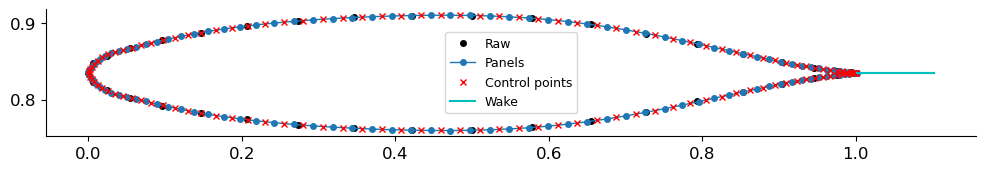

2×120 Matrix{Float64}:
 30.0  30.0  30.0  30.0  30.0  30.0  …  30.0  30.0  30.0  30.0  30.0  30.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0

In [144]:
#=##############################################################################
# DESCRIPTION
    Fan duct replicating the experiment reported by V. P. Hill (1978), "A
    Surface Vorticity Theory for Propeller Ducts and Turbofan Engine Cowls in
    Non-Axisymmetric Incompressible Flow." The same experiment is also
    discussed in Sections 4.4 and 6.3.1 of Lewis, R. (1991), "Vortex Element
    Methods for Fluid Dynamic Analysis of Engineering Systems."
=###############################################################################

import FLOWPanel as pnl
import CSV
import DataFrames: DataFrame


save_path       = "/home/juddmehr/code-development/DuctAPE.jl/dev_debug_archive/new_panels/"     # Where to save outputs
run_name        = "duct"                    # Name of this run

verbose         = true                      # Wheter to verbose
v_lvl           = 0                         # Verbose indentation level
paraview        = !true                      # Wheter to call ParaView


# ----------------- SIMULATION PARAMETERS --------------------------------------
magVinf         = 30.0                      # (m/s) freestream velocity
rho             = 1.225                     # (kg/m^3) air density


# ----------------- GEOMETRY DESCRIPTION ---------------------------------------
# Read duct contour (table in figure 7.4 of Lewis 1991)
filename        = joinpath(pnl.examples_path, "data", "naca662015.csv")
contour         = CSV.read(filename, DataFrame)

aspectratio     = 0.6                       # Duct trailing edge aspect ratio l/d
d               = 2*0.835                   # (m) duct diameter


# ----------------- SOLVER PARAMETERS ------------------------------------------
# Discretization

# NOTE: NDIVS is the number of divisions (panels) in each dimension. This can be
#       either an integer, or an array of tuples as shown below

n_rfl           = 20                        # This controls the number of chordwise panels

NDIVS_rfl_up = [                            # Discretization of airfoil upper surface
            # 0 to 0.25 of the airfoil has `n_rfl` panels at a geometric expansion of 10 that is not central
                (0.25, n_rfl,   10.0, false),
            # 0.25 to 0.75 of the airfoil has `n_rfl` panels evenly spaced
                (0.50, n_rfl,    1.0, true),
            # 0.75 to 1.00 of the airfoil has `n_rfl` panels at a geometric expansion of 0.1 that is not central
                (0.25, n_rfl,    0.1, false)]

NDIVS_rfl_lo = NDIVS_rfl_up                 # Discretization of airfoil lower surface

# NOTE: A geometric expansion of 10 that is not central means that the last
#       panel is 10 times larger than the first panel. If central, the
#       middle panel is 10 times larger than the peripheral panels.


# ----------------- GENERATE AIRFOIL CONTOUR -----------------------------------
# Re-discretize the contour of the body of revolution according to NDIVS
xs, ys = gt.rediscretize_airfoil(contour[:, 1], contour[:, 2],
                                        NDIVS_rfl_up, NDIVS_rfl_lo;
                                        verify_spline=false)

# Make sure that the contour is closed
# NOTE: Closing the contour makes the problem ill-conditioned since
#       one of the degrees of freedom dissappears
ys[end] = ys[1]

# Scale contour by duct length
xs *= d*aspectratio
ys *= d*aspectratio

# Move contour to the radial position
ys .+= d/2

# Revert points to make the normals point outwards
reverse!(xs)
reverse!(ys)

f = open("ed_duct_geom.jl", "w")
write(f,"duct_coordinates = [")
for i in 1:length(xs)
    write(f, "$(xs[i]) $(ys[i])\n")
end
write(f, "]")
close(f)

# Verify discretization
fig = plt.figure(figsize=[12, 5])
ax = fig.gca()

ax.plot(contour[!, 1], contour[!, 2] .+ d/2, ".k", linewidth=1, markersize=8, clip_on=false, label="Raw")
ax.plot(xs, ys, ".-", linewidth=1, markersize=8, clip_on=false, label="Panels")
ax.set_aspect("equal")

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)

vtks = save_path*"/"                        # String with VTK output files



# ----------------- GENERATE PANELED BODY --------------------------------------
# Collect points that make the contour of the body of revolution
nodes = collect(transpose(hcat(xs, ys)))
panels = [[i, i+1] for i in 1:size(nodes, 2)-1]

npanels = length(panels)

controlpoints = calc_controlpoints(nodes, panels)
normals = calc_normals(nodes, panels)

ax.plot(controlpoints[1, :], controlpoints[2, :], "xr", markersize=4, label="Control points")

# Define trailing edge
wakes = [[npanels, 1]]
# wakes = Vector{Int}[]

# Plot wake for verification
for wake in wakes
    # Iterate over TE sides
    for (i, paneli) in enumerate(wake)
        # i is used to determine side (i==1 => upper, i=2 => lower)

        # Fetch panel end points
        p1 = view(nodes, :, panels[paneli][1])
        p2 = view(nodes, :, panels[paneli][2])

        # Position of TE vortex
        pte = i%2==1 ? p2 : p1
        
        ax.plot([pte[1], pte[1] + 0.1*d*aspectratio], pte[2]*ones(2), "-c", label="Wake"^(i==1))
    end
    
end

ax.legend(loc="best", fontsize=9)


# ----------------- SOLVER -----------------------------------------------------
# Freestream at each control point
Uinf = magVinf*[1, 0]
Uinfs = repeat(Uinf, 1, npanels)



In [145]:
# Geometric matrix (left-hand side)
G = G_axisymdoublet(nodes, panels, controlpoints, normals)



120×120 Matrix{Float64}:
  274.756      -102.665       -17.2563     …    97.0172     -268.63
  -53.4807      185.934       -67.4394        -165.783        50.0738
   -8.10687     -42.3741      140.705           32.0959        7.93608
   -2.62286      -6.90772     -34.9086           6.44221       2.58438
   -1.13312      -2.38531      -5.93608          2.29014       1.11944
   -0.576103     -1.08598      -2.13484    …     1.05404       0.570028
   -0.325992     -0.57618      -1.00611          0.562465      0.322914
   -0.199168     -0.337734     -0.549704         0.330911      0.197466
   -0.128963     -0.212548     -0.330427         0.208807      0.127962
   -0.0874177    -0.141149     -0.212534         0.138952      0.0868007
   -0.0614986    -0.0977866    -0.143858   …     0.0964287     0.0611042
   -0.0446182    -0.0701133    -0.101355         0.06924       0.0443588
   -0.0332241    -0.0517254    -0.0737657        0.0511456     0.0330494
    ⋮                                      ⋱

In [146]:
# Add linear simple Kutta condition
G_kutta_linearsimple!(G, nodes, panels, controlpoints, normals, wakes; tol=1e-3)



120×120 Matrix{Float64}:
  137.349    -102.665       -17.2563     …    97.0172     -131.223
  -93.035     185.934       -67.4394        -165.783        89.6281
  -28.0496    -42.3741      140.705           32.0959       27.8789
  -14.8463     -6.90772     -34.9086           6.44221      14.8079
   -9.4516     -2.38531      -5.93608          2.29014       9.43793
   -6.62641    -1.08598      -2.13484    …     1.05404       6.62034
   -4.93589    -0.57618      -1.00611          0.562465      4.93281
   -3.83477    -0.337734     -0.549704         0.330911      3.83307
   -3.07362    -0.212548     -0.330427         0.208807      3.07262
   -2.52358    -0.141149     -0.212534         0.138952      2.52296
   -2.11203    -0.0977866    -0.143858   …     0.0964287     2.11163
   -1.79527    -0.0701133    -0.101355         0.06924       1.79501
   -1.54565    -0.0517254    -0.0737657        0.0511456     1.54547
    ⋮                                    ⋱                
    1.64993     0.066133

In [147]:
# Boundary condition vector (right-hand side)
b = bc_noflowthrough(nodes, panels, controlpoints, normals, Uinfs)



120-element Vector{Float64}:
 -1.0524909418963204
 -2.5957702111402057
 -2.794559987129176
 -3.0390262750842334
 -3.322555698332817
 -3.637368970113651
 -3.974698981210213
 -4.325004717883892
 -4.678211358232693
 -5.023961701726323
 -5.351861768730128
 -5.6517035749662226
 -5.91365192451281
  ⋮
 -5.651703574966264
 -5.351861768730172
 -5.0239617017262335
 -4.678211358232986
 -4.325004717883615
 -3.9746989812101647
 -3.637368970114121
 -3.322555698332817
 -3.039026275084114
 -2.794559987129176
 -2.5957702111392407
 -2.447966064139045

In [148]:
# # Doublet strengths through direct linear solver
# mus = G\b

# Prescribe the strength of an arbitrary panel to be zero
prescribedpanels = [(1, 0.0)]

# Convert the ill-conditioned linear system of equations to a least-squares problem
Gls, bls = G_leastsquares(G, b, prescribedpanels)
display(Gls)
display(bls)


119×119 Matrix{Float64}:
  85124.1      -26650.7        -906.372    …  -84454.2      56645.0
 -26650.7       40423.4      -13316.3          26021.8       -358.272
   -906.372    -13316.3       22113.7           1117.54      -313.533
   -272.076      -540.117     -7686.73           294.195     -197.948
   -129.708      -139.977      -326.303          136.223     -130.619
    -75.6077      -55.5817      -95.1931   …      78.6249     -90.8549
    -49.1377      -28.5328      -36.4525          50.8832     -65.9238
    -34.1982      -17.123       -17.4919          35.3384     -49.4207
    -24.9602      -11.3549       -9.83885         25.7621     -38.0122
    -18.8723       -8.05264      -6.18784         19.4648     -29.8554
    -14.6667       -5.98746      -4.21377  …      15.1203     -23.867
    -11.6533       -4.60978      -3.04002         12.0101     -19.3749
     -9.42968      -3.64504      -2.28931          9.7164     -15.9429
      ⋮                                    ⋱               


119-element Vector{Float64}:
 -153.53028038475998
  -28.59312010276369
   -9.825373035822622
   -3.4906019816985463
   -0.9595426771348912
   -0.008253251601104239
    0.16572173378540356
   -0.07989459108839014
   -0.5529810076000672
   -1.1365939617092522
   -1.756532819817977
   -2.3640617384508857
   -2.9250573760163547
    ⋮
   -1.7684246104646206
   -1.079669340509895
   -0.3080070766012568
    0.5321677850614037
    1.4251943987279674
    2.3721654934579135
    3.4331015561976983
    4.855612228371001
    7.689340923106215
   18.16384883432272
  126.39247058345018
 -222.1112722169977

In [149]:
# Solve the least-squares problem with a linear solver returning the reduced strengths
mureds = Gls\bls



119-element Vector{Float64}:
 0.2415968152798092
 0.4031914417795244
 0.5507684754689297
 0.70331037533175
 0.8701638932868935
 1.057318211351004
 1.2690734923106994
 1.508706127879095
 1.7788692825470884
 2.081885322538055
 2.4199515712703383
 2.795267231512141
 3.210098591881513
 ⋮
 4.7940261718391355
 4.4612598847836
 4.161801037938462
 3.8938173965572713
 3.655289523037476
 3.4438109534206567
 3.2563017482102423
 3.0886126760382955
 2.9348600901075486
 2.7857419523010347
 2.622171485977568
 2.376813911489578

In [150]:
# Build the full vector of strengths
mus = mured2mu(mureds, prescribedpanels)




120-element Vector{Float64}:
 0.0
 0.2415968152798092
 0.4031914417795244
 0.5507684754689297
 0.70331037533175
 0.8701638932868935
 1.057318211351004
 1.2690734923106994
 1.508706127879095
 1.7788692825470884
 2.081885322538055
 2.4199515712703383
 2.795267231512141
 ⋮
 4.7940261718391355
 4.4612598847836
 4.161801037938462
 3.8938173965572713
 3.655289523037476
 3.4438109534206567
 3.2563017482102423
 3.0886126760382955
 2.9348600901075486
 2.7857419523010347
 2.622171485977568
 2.376813911489578

In [151]:
# ---------------- GENERATE FLUID DOMAIN ---------------------------------------
# Bounds of grid
Pmax = d*[aspectratio*1.5, 0.5*1.35, 0] # Upper bound
Pmin = d*[-aspectratio*0.35, eps(), 0]            # Lower bound

# Grid discretization
dx         = 0.005*d*aspectratio                            # Cell size
# dx         = 0.0005*d*aspectratio
# dx         = 0.001*d*aspectratio
dr         = dx

NDIVS = ceil.(Int, (Pmax .- Pmin) ./ [dx, dr, 1]) # Divisions in each dimension


# Generate grid
@time grid  = gt.Grid(Pmin, Pmax, NDIVS) # Grid

if verbose; println("\t"^(v_lvl+1)*"Grid size:\t\t$(NDIVS)"); end;
if verbose; println("\t"^(v_lvl+1)*"Number of nodes :\t$(grid.nnodes)"); end;

# Targets where to probe the velocity
targets = grid.nodes
ntargets = size(targets, 2)


  0.039321 seconds (1.42 M allocations: 54.364 MiB)
	Grid size:		[370, 225, 0]
	Number of nodes :	83846


83846

In [152]:
# Velocity at each target
Us = repeat(Uinf, 1, ntargets) 
Us += Ubody(targets, nodes, panels, mus)
Us += Uwake(targets, nodes, panels, mus, wakes; tol=1e-3)
Us = [[U[1], U[2], 0] for U in eachcol(Us)]

# Pressure field
Cps = 1 .- (norm.(Us)/magVinf).^2

# Save fields
gt.add_field(grid, "U", "vector", Us, "node")
gt.add_field(grid, "Cp", "scalar", Cps, "node")

# Output fluid domain
@time vtks = gt.save(grid, run_name; path=save_path, format="vtk")

  0.537825 seconds (9.76 M allocations: 577.547 MiB, 12.81% gc time)


"duct.vtk;"

## checking $\mathbf{V}\cdot\hat{n}$

In [171]:
using Statistics
function checkvdotn(V, n)                                          
    vdn = dt.dot.(eachcol(V), eachcol(n))
    println("\tMax error V dot n = ", maximum(vdn))
    println("\tMean error V dot n = ", mean(vdn))
    println("\tMedian error V dot n = ", median(vdn))
    return vdn
end

checkvdotn (generic function with 1 method)

In [172]:
# Output paneled body
Us_cp = Uinfs 
checkvdotn(Uinfs,normals);

	Max error V dot n = 6.405965188693122
	Mean error V dot n = -1.718299073609041
	Median error V dot n = 0.5472585519803661


In [173]:
Us_b = Ubody(controlpoints, nodes, panels, mus) 
Us_cp += Us_b
display(Us_b')
checkvdotn(Us_cp,normals);

120×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -27.1795   326.889
 -23.244     94.9512
 -20.8494    48.4594
 -19.2397    30.2933
 -18.2855    21.192
 -17.6981    15.9808
 -17.3147    12.7388
 -17.0444    10.6067
 -16.8331     9.14915
 -16.646      8.1245
 -16.4598     7.38895
 -16.2593     6.8516
 -16.0342     6.45178
   ⋮        
 -15.2575     1.08344
 -15.279      1.96143
 -15.261      3.05158
 -15.2047     4.43807
 -15.1109     6.25864
 -14.9777     8.74899
 -14.7949    12.3388
 -14.5308    17.8817
 -14.0889    27.2899
 -13.1217    45.7096
  -9.87914   92.201
  10.7856   323.226

	Max error V dot n = 325.4757390402478
	Mean error V dot n = -0.022966966796098612
	Median error V dot n = 0.19056570175268636


In [174]:
Us_w = Uwake(controlpoints, nodes, panels, mus, wakes; tol=1e-3)
Us_cp += Us_w
display(Us_w')
checkvdotn(Us_cp,normals);

120×2 adjoint(::Matrix{Float64}) with eltype Float64:
  13.1909     -326.329
   6.80362     -93.7762
   4.77569     -47.1605
   3.58727     -28.8379
   2.87954     -19.573
   2.42166     -14.1915
   2.10361     -10.7731
   1.8697       -8.45998
   1.68952      -6.81886
   1.5454       -5.61074
   1.42644      -4.69456
   1.32565      -3.98255
   1.23833      -3.41771
   ⋮          
   0.158255     -3.92019
   0.128408     -4.63422
   0.0859102    -5.55245
   0.0244307    -6.76246
  -0.066419     -8.40499
  -0.204551    -10.7186
  -0.422908    -14.1353
  -0.78752     -19.5105
  -1.44775     -28.7572
  -2.80939     -47.022
  -6.39171     -93.3908
 -24.8356     -324.53

	Max error V dot n = 0.04434472169242132
	Mean error V dot n = 0.026048771138146496
	Median error V dot n = 0.027659313401072527


In [175]:
vtks *= save_vtk(run_name, save_path, nodes, panels, mus, controlpoints, normals; Us=Us_cp)

# Call ParaView
if paraview
    str = save_path*"/"*vtks
    run(`paraview --data=$(str)`)
end

In [176]:
#Us_gm = Ugradmu(nodes, panels, mus, wakes)

Us_gm = Ugradmugg(nodes, panels, mus, wakes)
Us_gm.*=-1

2×120 Matrix{Float64}:
 -234.929   31.0796  17.3382   13.3438   …  17.7131   31.6502   276.612
   -8.2471   2.6993   1.62214   1.35873     -1.65721  -2.74886  -22.6467

In [177]:
Us_cp += Us_gm
display(Us_gm')
checkvdotn(Us_cp,normals);

120×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -234.929    -8.2471
   31.0796    2.6993
   17.3382    1.62214
   13.3438    1.35873
   11.7893    1.31377
   11.1728    1.36472
   10.9901    1.46902
   11.0234    1.60598
   11.1671    1.76297
   11.3688    1.93115
   11.6032    2.10371
   11.8595    2.27495
   12.1337    2.43969
    ⋮       
   12.439    -2.38611
   12.1259   -2.19847
   11.8394   -2.0111
   11.5921   -1.83006
   11.4099   -1.66229
   11.3464   -1.51666
   11.5085   -1.40572
   12.1158   -1.35015
   13.6775   -1.39271
   17.7131   -1.65721
   31.6502   -2.74886
  276.612   -22.6467

	Max error V dot n = 0.04434472169661241
	Mean error V dot n = 0.0260487711365218
	Median error V dot n = 0.02765931340003336


## pressure and plotting

120-element Vector{Float64}:
 -52.315592749679475
  -1.2307430490074864
  -0.09555603404087609
   0.13918864507342155
   0.21702046024490085
   0.24381468577603083
   0.2484963327756592
   0.24195917030468472
   0.22891099608063248
   0.21136010469756905
   0.1900245799676903
   0.1650369855413042
   0.13630884129055232
   ⋮
   0.13917676588401573
   0.16511726719929554
   0.18739431044413246
   0.20572991371571459
   0.21927176206573118
   0.22586584712865054
   0.22060663136359493
   0.1922500477117033
   0.11101570596376786
  -0.1321228489139643
  -1.305329792683727
 -94.74010029386204

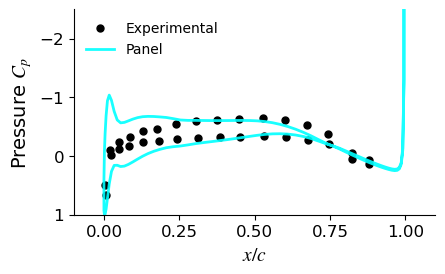

In [178]:
# Surface pressure
Cps = 1 .- (norm.(eachcol(Us_cp))/magVinf).^2
display(Cps)

xs = controlpoints[1, :] / (d*aspectratio)
xs .-= minimum(xs)

fig = plt.figure(figsize=[7, 5*0.8]*2/3)
ax = fig.gca()

# Plot experimental surface pressure (figures 4.8 and 6.4 in Lewis 1991)
Cps_exp = [
                0.006611570247933851 0.6680814940577251
                0.02479338842975201 -0.021222410865874286
                0.04958677685950391 -0.12308998302207141
                0.08264462809917339 -0.16893039049236003
                0.12892561983471057 -0.2351443123938881
                0.18429752066115695 -0.2538200339558573
                0.24214876033057842 -0.2877758913412565
                0.3115702479338843 -0.3081494057724957
                0.3851239669421487 -0.31833616298811535
                0.45206611570247934 -0.328522920203735
                0.5297520661157025 -0.3336162988115449
                0.6024793388429752 -0.33022071307300527
                0.6760330578512396 -0.26910016977928664
                0.7479338842975207 -0.21307300509337868
                0.8223140495867767 0.055178268251273255
                0.8801652892561982 0.13157894736842102
                0.0049586776859503745 0.4864176570458403
                0.020661157024793292 -0.09762308998302205
                0.04876033057851231 -0.24533106960950757
                0.08512396694214858 -0.3183361629881155
                0.12892561983471068 -0.42869269949066197
                0.177685950413223 -0.46774193548387083
                0.2380165289256197 -0.5492359932088285
                0.30661157024793373 -0.5933786078098472
                0.3752066115702479 -0.6222410865874364
                0.44793388429752046 -0.6392190152801358
                0.5264462809917354 -0.6528013582342954
                0.5991735537190083 -0.6171477079796265
                0.6735537190082643 -0.5356536502546689
                0.7446280991735537 -0.3777589134125636
                0.8223140495867769 -0.04668930390492365
                0.8801652892561984 0.07555178268251284
            ]

ax.plot(Cps_exp[:, 1], Cps_exp[:, 2], "ok", markersize=5, label="Experimental")

# Plot predicted
ax.plot(xs, Cps, "-", color="cyan", linewidth=2.0, alpha=0.9, label="Panel")

# Beautify the plot
xlims = [-0.1, 1.1]
ylims = [1.0, -2.5]
ax.set_xlim(xlims)
ax.set_xticks(0:0.25:1.0)
ax.set_ylim(ylims)
ax.set_yticks(ylims[1]:-1.0:ylims[2])

ax.set_xlabel(L"x/c")
ax.set_ylabel(L"Pressure $C_p$")
ax.legend(loc="best", frameon=false, fontsize=10)

ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)